In [1]:
from ultralytics import YOLO
import PIL
from PIL import Image
import numpy as np
import base64
import io
import yaml
from Prompt import SYSTEM_PROMPT, USER_PROMPT

#### rule-based setting for HTP test

In [2]:
trained_yolo = YOLO('/work/creative_self_motivated/runs/child_painting/run1/weights/best.pt')


image 1/1 /work/creative_self_motivated/dataset/child_painting/images/valid/000001.jpg: 1280x1280 1 가지, 1 구름, 1 그네, 1 기둥, 3 꽃s, 1 나무전체, 2 나뭇잎s, 1 다람쥐, 1 달, 1 별, 1 뿌리, 1 새, 1 수관, 3 열매s, 15.0ms
Speed: 12.0ms preprocess, 15.0ms inference, 1.8ms postprocess per image at shape (1, 3, 1280, 1280)


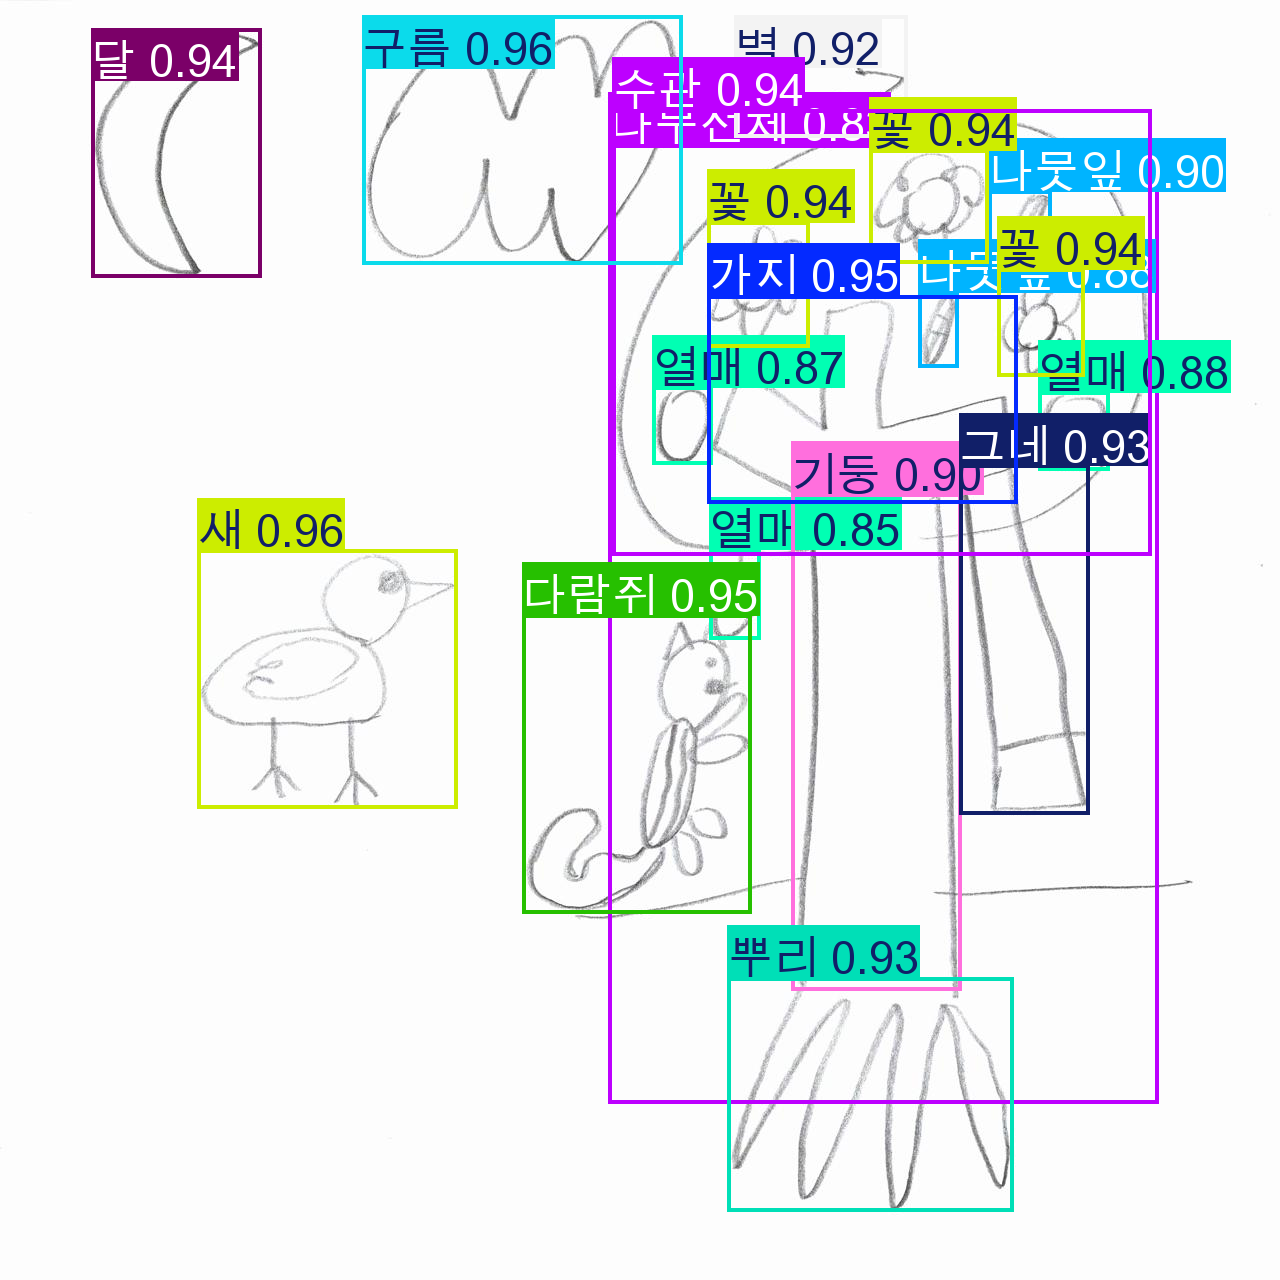

In [3]:
val_img = '/work/creative_self_motivated/dataset/child_painting/images/valid/000001.jpg'
# results = trained_yolo.predict(source=val_img, imgsz=1280, conf=0.25, iou=0.45, show=True, save=True)
results = trained_yolo(val_img)
for result in results:
    result.show()
    result.save('/work/creative_self_motivated/inference_results/val/000001.jpg')


image 1/1 /work/creative_self_motivated/dataset/child_painting/images/valid/000001.jpg: 1280x1280 1 가지, 1 구름, 1 그네, 1 기둥, 3 꽃s, 1 나무전체, 2 나뭇잎s, 1 다람쥐, 1 달, 1 별, 1 뿌리, 1 새, 1 수관, 3 열매s, 15.1ms
Speed: 10.6ms preprocess, 15.1ms inference, 1.3ms postprocess per image at shape (1, 3, 1280, 1280)


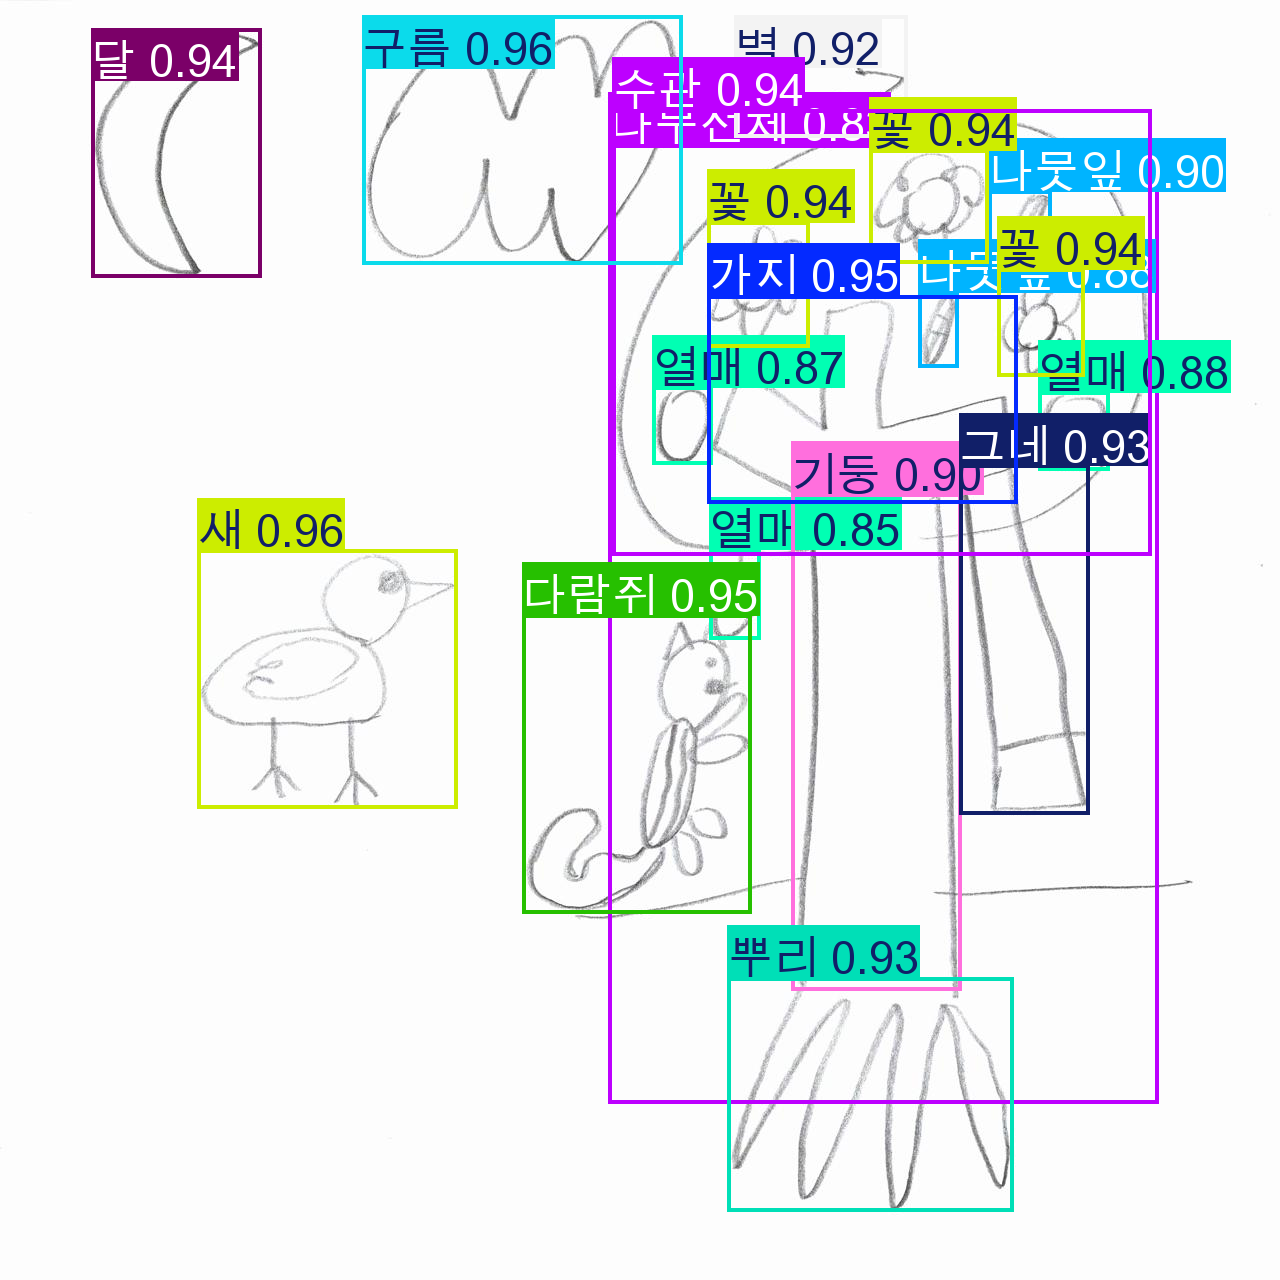

In [4]:
val_img = '/work/creative_self_motivated/dataset/child_painting/images/valid/000001.jpg'
# results = trained_yolo.predict(source=val_img, imgsz=1280, conf=0.25, iou=0.45, show=True, save=True)
results = trained_yolo(val_img)
for result in results:
    result.show()
    result.save('/work/creative_self_motivated/inference_results/val/000001.jpg')

In [ ]:
# https://blog.naver.com/wink4783/220022515082 -> HTP 투사검사 질문지 및 해석
# https://m.blog.naver.com/sswan77/222254918861 -> HTP 투사검사 해석

# HTPTest class
class HTPTest:
    def __init__(self, person_name, person_age, drawing_time, cls_config_file, api_model, paper_type='A4'):
        self.person_name = person_name # 사람 이름
        self.person_age = person_age # 사람 나이
        self.drawing_time = drawing_time # 각 HTP (House, Tree, Person1, Person2(반대 성으로))에 소요된 시간
        self.total_drawing_t = sum(drawing_time) # 총 그리는데 걸리는 시간
        self.img_loaded = False # load_img 호출시 True
        
        self.api_model = api_model # OpenAI API 에서 사용할 모델 이름 (이미지 분석이 있기 때문에, text, image input의 multi-modal 모델이어야 한다. )
        self.paper_type = paper_type # 사용할 종이 종류
        self._paper_size_cm = {
            'A4': (21, 29.7), # width, height
        }
        self.detector_ran = False # run_detector 호출시 True
        with open(cls_config_file, 'r') as fr:
            self.cls_config = yaml.load(fr, Loader=yaml.FullLoader) # config settings for yolo classification
        self.idx2cls = self.cls_config['names'] # 자세한 클래스 이름 및 인덱스 배정은 child_painting.yaml 파일을 참조
        self.cls2idx = {v: k for k, v in self.idx2cls.items()}
        self.htp_imgs = []
        self.client = None # OpenAI API client
        
    # htp 이미지들을 로딩하는 함수, 해당 함수를 먼저 호출해야 이후에 run_detector를 수행할 수 있다.     
    def load_img(self, imgs, direct_input=False):
        # direct_input: True인 경우 이미지 객체를 (PIL형태를 따름) 직접 입력, False인 경우 이미지 경로를 기반으로 로드
        # direct_input=True인 경우 각 이미지들은 python 배열로 둘러싸여 있어야 함
        if direct_input:
            self.htp_imgs = imgs # 이미지 배열 (HTP 검사 순서에 따라, House -> Tree -> Person1 -> Person2 순서를 가짐)
        else:
            for img in imgs:
                self.htp_imgs.append(np.asarray(Image.open(img))) # numpy 객체 형태로 전환
        
        self.img_loaded=True
    
    # HTP 분석 결과 history 초기화하기
    def clear(self):
        self.img_loaded=False
        self.htp_imgs = []
        self.drawing_time = None
        self.total_drawing_t = None
        self.person_name = ""
    
    # htp 이미지 업데이트
    def update_img(self, htp_type, img, direct_input=False):
        htp_type = {'house': 0, 'tree': 1, 'person1': 2, 'person2': 3}
        if not self.img_loaded:
            raise Exception("Image Must be Loaded First!")
        if not direct_input:
            img = np.asarray(Image.open(img))
        self.htp_imgs[htp_type] = img
    
    # object detector 수행
    def run_detector(self, weight_path):
        trained_yolo = YOLO(weight_path)
        self.detected_result = []
        for img in self.htp_imgs:
            self.detected_result.append(trained_yolo(img))
        
        self.detector_ran = True
    
    # OpenAI API client 생성  
    def create_client(self, api_key):
        from openai import OpenAI
        self.client = OpenAI(api_key=api_key)
    
    # byte 타입으로 저장하고 base64로 인코딩하기
    def encode_base64(self, img):
        # 입력 이미지는 반드시 PIL 이미지 객체이어야 한다.
        if not isinstance(img, PIL.Image.Image):
            raise TypeError("Input must be a PIL Image object.")
        buffered = io.BytesIO()
        img.save(buffered, format="PNG")
        root_img = buffered.getvalue()

        base64_str = base64.b64encode(root_img).decode('utf-8')
        data_url = f"data:image/png;base64, {base64_str}"
        return data_url 
    
    # OpenAI API를 호출하고 결과 메시지를 반환한다.
    def call_api(self, models, system_prompt, user_prompt, image_urls):
        if self.client is None:
            raise Exception("OpenAI Client must be created first. Please call create_client() method with your API key.")
        messages = []
        
        if system_prompt is not None:
            messages.append({'role': 'system', 'content': system_prompt})
        if user_prompt is not None:
            content = []
            content.append({'type': 'text', 'text': user_prompt})
            if image_urls is not None:
                for image_url in image_urls:
                    content.append({'type': 'image_url', 'image_url': {'url': image_url}})
            messages.append({'role': 'user', 'content': content})
        else:
            raise Exception("User Prompt must be provided!")
        
        completion = self.client.chat.completions.create(
            model=models,
            store=True,
            messages=messages)

        # return generated text only
        return completion
    
    # API response가 1. yes\n 2. no\n 3. yes \n와 같이 yes나 no만 나오고, 각 줄마다 답변이 나오는 경우 이중에 yes나 no만 추출하는 함수
    def preprocess_answer(self, completion):
        answer = [x.strip() for x in completion.choices[0].message.content.split('\n')]
        answer = [x.split(':')[-1].strip().lower() for x in answer if ':' in x]
        return answer # ['yes', 'no', 'yes' ....] 이런 형식으로 반환된다.
    
    # 이미지 전체에서 일부 영역만 잘라내기
    def cut(self, img, loc):
        # img: [h, w, channel] 형태의 이미지
        # loc: [x, y, width, height] 형태로 입력
        return img[int(loc[1]):int(loc[1])+int(loc[3]), int(loc[0]):int(loc[0])+int(loc[2])]
        
    # A4 사이즈 용지에서 수행한다고 가정하면 -> 21 x 29.7 cm
    def HTP_analysis(self):
        
        if not self.img_loaded:
            raise Exception("Image Must be Loaded First!")
        if not self.detector_ran:
            raise Exception("Inference Detector First!")
        
        htp_analysis = [] # list of strings that contains analysis result
        htp_type = ['house', 'tree', 'person1', 'person2']
        
        for htp, results in zip(htp_type, self.detected_result):
            analysis = []
            for i in range(len(results)):
                result = results[i]
                img_shape = result.orig_shape # (height, width)
                ori_img = result.orig_img # original image
                boxes = result.boxes
                box_cls = boxes.cls.int().detach().cpu().numpy()
                box_loc = boxes.xywhn.detach().cpu().numpy() # normalize된 버전의 좌표
                box_loc_p = boxes.xywh.detach().cpu().numpy() # normalize 되지 않는 원래 좌표
                box_area = box_loc[:, 2] * box_loc[:, 3]
                num_boxes = len(boxes) # number of boxes
                
                # byte 타입으로 저장하고 base64로 인코딩 (OpenAI API는 이미지 입력으로 raw-type을 받지 않기 때문에, url형태로 변환하여 전송해야 한다.)
                ori_data_url = self.encode_base64(Image.fromarray(ori_img))
                
                if htp == 'person1' or htp == 'person2':
                    ################### 사람 그림에서 사람이 존재하는지 검사 ##################
                    person_xywhn = box_loc[box_cls==self.cls2idx['사람전체']]
                    if len(person_xywhn) >= 1:
                        person_xywhn = person_xywhn[np.argmax(person_xywhn[:, 2] * person_xywhn[:, 3])] # 가장 큰 집 bbox를 선택
                    else:
                        print("Person BBoxes are not found on the image!")
                        raise Exception("There is no any Person detected. Please resubmit the image with Person drawn on it.")
                    person_area = person_xywhn[2] * person_xywhn[3] # area of the person bbox
                    
                    ##################### 사람 크기에 대한 분석 #####################
                    # 아주 크게 그리거나 작게 그린 경우 (용지에 80% 이상을 사용하였거나, 10%미만 사용했을 경우) 또한 전체 object 갯수가 3개 이하의 공허하게 그려진 경우
                    if (person_area >= 0.8 or person_area < 0.1) and num_boxes <= 3:
                        analysis.append(['정서장애'])
                    # 보통 사이즈보다 조금 더 작은 경우
                    elif person_area >= 0.15 and person_area <= 0.3:
                        # 도화지의 상부에 그려진 경우
                        if person_xywhn[1] <= 0.3:
                            analysis.append(['열등감, 무능력함, 억제, 소심, 낮은 에너지 수준, 이치에 맞지 않는 낙천주의'])
                        else:
                            analysis.append(['열등감, 무능력함, 억제, 소심'])
                    # 보통 사이즈보다 아주 더 작은 경우
                    elif person_area < 0.15:
                        analysis.append(['수축된 자아, 심한 우울증'])
                    # 보통 사이즈보다 아주 큰 경우
                    elif person_area >= 0.8:
                        analysis.append(['조증환자, 아동정신적 장애, 기절적 장애'])
                        
                    # 인물화에 집이 포함되어 있는경우
                    if (box_cls==self.cls2idx['집전체']).any():
                        house_idx = box_cls==self.cls2idx['집전체']
                        box_house = box_loc[house_idx]
                        max_house_size = np.max(box_house[:, 2] * box_house[:, 3]) # 최대 집 크기
                        if person_area - max_house_size >= 0.10: # 사람의 크기가 집보다 큰 경우
                            analysis.append(['가족보다는 자신을 더 중요시한다는 경향'])
                    
                    ###################### 사람 머리에 대한 분석 ######################
                    head_xywhn = box_loc[box_cls==self.cls2idx['머리']]
                    if len(head_xywhn) >= 1:
                        head_xywhn = head_xywhn[np.argmax(head_xywhn[:, 2] * head_xywhn[:, 3])] if len(head_xywhn) > 0 else None
                        head_area = head_xywhn[2] * head_xywhn[3]
                        if head_area / person_area < 0.12: # 작은 머리 (전체 사람 면적의 12% 미만)
                            analysis.append(['강박증 환자들, 지적 부족감'])
                        elif head_area / person_area >= 0.33: # 큰 머리 (전체 사람 면적의 33% 이상)
                            analysis.append(['아동, 강한 지적 노력, 지적 성취에 대한 압박, 공격성, 자기중심적인 태도, 편집증'])
                    else: # 머리를 그리지 않는 경우
                        analysis.append(['사고 장애, 신경학적 장애, 물건이나 모자 등에 머리가 다 가려지게 그리는 경우 자신의 지적 능력에 자신감이 없고 불안감을 느낌'])
                    
                    ###################### 사람 얼굴에 대한 분석 ######################
                    face_xywh = box_loc_p[box_cls==self.cls2idx['얼굴']]
                    if len(face_xywh) >= 1:
                        face_xywh = face_xywh[np.argmax(face_xywh[:, 2] * face_xywh[:, 3])]
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, face_xywh))))
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['사람']['얼굴'].format(face_xywh[0], face_xywh[1], face_xywh[2], face_xywh[3]),
                                                    image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        if answer[0] == 'yes': # 뒤통수로 그려진 경우
                            analysis.append(['세상과 직면하기를 원하지 않는 것, 외모에 대한 극도의 불안감, 세상에 대해 억제적이고 회피적인 태도, 억압된 분노감이나 거부적인 태도'])
                        elif answer[1] == 'yes': # 옆얼굴로 그려진 경우
                            analysis.append(['자신감 부족, 직접적인 사회적 접촉을 피하고 싶음'])
                        if answer[2] == 'yes': # 수염이 그려진 경우
                            analysis.append(['쾌락이나 힘, 남성적인 면이 부족하다는 생각으로 불안감에 이를 보상하려고 함'])
                    
                    
                    ######################## 사람 눈에 대한 분석 #######################
                    eye_idx = box_cls==self.cls2idx['눈']
                    eye_xywh = box_loc_p[eye_idx]
                    eye_xywhn = box_loc[eye_idx]
                    if len(eye_xywh) >= 1:
                        max_idx = np.argmax(eye_xywh[:, 2] * eye_xywh[:, 3])
                        eye_xywhn = eye_xywhn[max_idx]
                        eye_xywh = eye_xywh[max_idx]
                        eye_area = eye_xywhn[2] * eye_xywhn[3]
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, eye_xywh))))
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['사람']['눈'].format(eye_xywh[0], eye_xywh[1], eye_xywh[2], eye_xywh[3]),
                                                     image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        if answer[0] == 'yes': # 한쪽 눈만 그림
                            analysis.append(['감정교류에 있어서 접근과 회피의 양가감정'])
                        elif answer[1] == 'yes': # 머리카락이나 모자로 눈을 가림
                            analysis.append(['사회적 불안으로 감정을 표현하고 타인의 감정을 수용하는데 매우 위축되어 있음 다른 사람에 대한 적개심'])
                        if answer[2] == 'yes': # 눈을 강조해서 그림
                            analysis.append(['감정적 교류에 있어서 불안감과 긴장감 타인과의 상호작용에서 의심이나 방어적 태도, 편집증적인 경향성'])
                        if answer[3] == 'yes': # 눈동자 없는 눈 윤곽을 그린 경우
                            analysis.append(['내적인 공허감 타인의 감정을 알고 싶지도 자신의 감정을 보이고 싶지도 않음'])
                        if answer[4] == 'yes': # 점, 가느다란 선으로 그림 경우
                            analysis.append(['감정 교류 소통의 채널을 좁힘. 타인과의 감정 교류나 감정 표현에 있어 스스로 한계를 느낌'])
                        if answer[5] == 'yes': # 눈꺼풀, 속눈썹을 그린 경우
                            analysis.append(['타인과 정서적으로 교류하는 것에 과민, 집착, 정교한 경우는 강박적 성격, 히스테리적 성격, 자기애적 성격'])
                        if answer[6] == 'yes': # 정돈된 눈썹 그린 경우
                            analysis.append(['세련되고 몸치장을 잘함'])
                        elif answer[7] == 'yes': # 위로 올라간 눈썹으로 그린 경우
                            analysis.append(['경멸하거나 건방진 태도'])
                        if answer[8] == 'yes': # 진한 눈썹으로 그린 경우
                            analysis.append(['야성적, 거친, 억제되지 않음'])
                        
                        if eye_area / person_area < 0.005: # 눈을 너무 작게 그림
                            analysis.append(['사회적 상호작용에서 위축되고 회피하고자 함. 자아도취'])
                        elif eye_area / person_area > 0.02: # 눈을 너무 크게 그림
                            analysis.append(['타인과 정서적 교류에 있어서 지나치게 예민함'])
                    else: # 눈을 그리지 않는 경우
                        analysis.append(['타인과 감정을 교류하는데 극심한 불안감을 느낌 사고장애의 가능성'])
                    
                        
                    ####################### 사람의 귀에 대한 분석 ######################
                    ear_idx = box_cls==self.cls2idx['귀']
                    ear_xywhn = box_loc[ear_idx]
                    ear_xywh = box_loc_p[ear_idx]
                    if len(ear_xywhn) >= 1:
                        max_idx = np.argmax(ear_xywhn[:, 2] * ear_xywhn[:, 3])
                        ear_xywhn = ear_xywhn[max_idx]
                        ear_xywh = ear_xywh[max_idx]
                        ear_area = ear_xywhn[2] * ear_xywhn[3]
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, ear_xywh))))
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['사람']['귀'].format(ear_xywh[0], ear_xywh[1], ear_xywh[2], ear_xywh[3]),
                                                    image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        
                        if answer[0] == 'yes': # 귀를 강조한 경우
                            analysis.append(['감정 교류에 대한 불안감과 긴장감, 다른 사람이 나를 어떻게 생각 하는가에 대한 예민함, 타인의 의도에 대한 불신이나 의심'])
                        if answer[1] == 'yes': # 귀걸이를 그린 경우
                            analysis.append(['피검자가 외모에 관심이 많음, 너무 정교하다면 타인에게 자신을 과시하고 드러내고 싶어하는 자기애적 욕구, 대인관계 불안감을 강박적으로 보상하고자 하는 욕구'])
                            
                        if ear_area / person_area < 0.0020: # 귀를 너무 작게 그림
                            analysis.append(['정서적 자극을 피하고 싶고 위축되어 있음'])
                        elif ear_area / person_area >= 0.01: # 귀를 너무 크게 그림
                            analysis.append(['대인관계 상황에서 너무 예민함'])
                    else: #귀를 그리지 않는 경우
                        analysis.append(['아동, 정서적 교류나 감정표현에 대해 불안하고 자신이 없어함'])
                        
                    ####################### 코의 크기에 따른 분석 #######################
                    nose_xywh = box_loc_p[box_cls==self.cls2idx['코']]
                    if len(nose_xywh) >= 1:
                        nose_xywh = nose_xywh[np.argmax(nose_xywh[:, 2] * nose_xywh[:, 3])]
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, nose_xywh))))
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['사람']['코'].format(nose_xywh[0], nose_xywh[1], nose_xywh[2], nose_xywh[3]), image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        
                        if answer[0] == 'yes': # 삼각형 모양의 코로 묘사된 경우
                            analysis.append(['권력 투쟁, 유아기적 성'])
                        if answer[1] == 'yes': # 긴코를 묘사한 경우
                            analysis.append(['공격성, 우월을 탐함. 외형적이고 활동적임'])
                        if answer[2] == 'yes': # 날카로운 코를 묘사한 경우
                            analysis.append(['상당한 공격성을 가지고 우월성을 추구'])
                        if answer[3] == 'yes': # 매부리코를 묘사한 경우
                            analysis.append(['나쁘고 탐욕스러운 사고의 표시'])
                        if answer[4] == 'yes': # 콧구멍이 강조되어 있는 경우
                            analysis.append(['경험적으로 대인관계 상호작용에서 매우 미성숙한 태도와 공격적인 행동을 보일 소지가 높음'])
                        if answer[5] == 'yes': # 코가 큰 인물화가 그려진 경우
                            analysis.append(['초기의 우울증 환자가 그리는 경향 자신의 남성적역할을 하는 것을 부정하는 사람도 큰 코를 그리는 경향이 있음'])
                        if answer[6] == 'yes': # 음영진 코를 가진 경우
                            analysis.append(['여성에 대한 약점을 투사한 유아적인 남성에 있어서 거세의 감정'])
                    else: # 코가 생략되어 있는 경우
                        analysis.append(['성에 대해 무엇인가 갈등이 있으며 남성적인 것을 거부하며 거세불안이 있고 동성애 경향이 있을 가능성이 있음 타인에게 어떻게 보일지에 매우 예민하고 두려워 함'])
                        
                    ################### 입의 크기에 따른 분석 ##################
                    mouth_idx = box_cls==self.cls2idx['입']
                    mouth_xywhn = box_loc[mouth_idx]
                    mouth_xywh = box_loc_p[mouth_idx]
                    if len(mouth_xywhn) >= 1:
                        max_idx = np.argmax(mouth_xywhn[:, 2] * mouth_xywhn[:, 3])
                        mouth_xywh = mouth_xywh[max_idx]
                        mouth_xywhn = mouth_xywhn[max_idx]
                        mouth_area = mouth_xywhn[2] * mouth_xywhn[3]
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, mouth_xywh))))
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['사람']['입'].format(mouth_xywh[0], mouth_xywh[1], mouth_xywh[2], mouth_xywh[3]),
                                                    image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        
                        if answer[0] == 'yes': # 내소적인 비웃음을 표현한 경우
                            analysis.append(['성격적으로 적대감, 공격성이 내제'])
                        if answer[1] == 'yes': # 웃는 모습으로 표현한 경우
                            analysis.append(['타인의 애정을 지나치게 원하며 인밀한 관계에 너무 몰두하고자함'])
                        if answer[2] == 'yes': # 벌린 입으로 표현한 경우
                            analysis.append(['대인관계 상호작용에서의 무기력감과 수동적인 태도'])
                        if answer[3] == 'yes': # 이를 그린 경우
                            analysis.append(['5세 이하의 경우: 행복감, 기쁨. 6세 이하의 경우: 정서적인 욕구충족, 애정욕구 충족에 있어서 심한 좌절을 느낌. 상처받을까 하는 불안감을 느낌'])
                        
                        if mouth_area / person_area > 0.05: # 입이 너무 큰 경우
                            analysis.append(['타인과의 정서적 교류, 애정의 교류에 있어서 불안감을 느끼지만 과도하게 적극적이고 주장적이고 심지어 공격적인 태도를 취함으로써 역공포적으로 이러한 불안감을 보상받으려 함'])
                        elif mouth_area / person_area < 0.0020: # 입의 너무 작은 경우
                            analysis.append(['내적인 상처를 받지 않으려고 정서적 상호작용을 회피하거나 타인의 애정어린 태도를 거절하고자 함, 이와 관련하여 절망감이나 우울감을 느낌'])
                        elif mouth_xywhn[3] * img_shape[1] < 5 and mouth_xywhn[2] * img_shape[0] > 10: # 입을 가로선 하나로 표현한 경우
                            analysis.append(['타인과의 정서적 교류에서 무감각, 냉정한 태도'])                    
                    else: # 입을 생략한 경우
                        analysis.append(['애정 욕구의 강한 거부, 심한 죄의식, 천식환자, 우울', '부모와 같은 대상과의 관계에 상당한 갈등이나 결핍이 있음'])
                        
                    ################### 턱의 크기에 따른 분석 ##################
                    data_urls = [ori_data_url]
                    completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['사람']['턱'], image_urls=data_urls)
                    answer = self.preprocess_answer(completions)
                    
                    if answer[0] == 'yes':
                        analysis.append(['권위 도는 우월을 필요로 하거나 얻으려 애쓴다'])
                    if answer[1] == 'yes':
                        analysis.append(['특히 사회적 지위에서의 약함'])
                    if answer[2] == 'yes':
                        analysis.append(['자신의 목표를 향해 일하려는 힘의 상징'])
                    if answer[3] == 'yes':
                        analysis.append(['염소수염: 특이한 방법으로서 사내다움을 나타내려는 남자다움에 대한 상징적인 표시의 욕구, 예술가, 반사회적인 사람'])
                        
                    ################### 머리카락에 따른 분석 ##################
                    hair_idx = box_cls==self.cls2idx['머리카락']
                    hair_xywh = box_loc_p[hair_idx]
                    if len(hair_xywh) >= 1:
                        max_idx = np.argmax(hair_xywh[:, 2] * hair_xywh[:, 3])
                        hair_xywh = hair_xywh[max_idx]
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, hair_xywh))))
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['사람']['머리카락'].format(hair_xywh[0], hair_xywh[1], hair_xywh[2], hair_xywh[3]),
                                                    image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        
                        if answer[0] == 'yes':
                            analysis.append(['성적 부도덕 및 통제의 결여'])
                        if answer[1] == 'yes':
                            analysis.append(['활발한 공상'])
                        if answer[2] == 'yes':
                            analysis.append(['성격적으로 지나치게 자신감, 적극적, 자기주장적 행동, 공격적인 태도, 자기애적 성격, 히스테리적 성격'])
                        if answer[3] == 'yes':
                            analysis.append(['성적인 면에서 지나치게 수동적이거나 억제적인 태도'])
                        if answer[4] == 'yes':
                            analysis.append(['청소년인 경우 성욕에의 충동성, 알콜중독자와 편집증 여성의 망상에서 보여짐'])
                        if answer[5] == 'yes':
                            analysis.append('자기애적, 자기중심적, 자만심이 강함')
                        
                        
                if htp == 'house':
                    ################# HTP 'House'에 대해 집이 제대로 그려졌는지 검사 ##################
                    house_xywhn = box_loc[box_cls==self.cls2idx['집전체']]
                    if len(house_xywhn) >= 1:
                        house_xywhn = house_xywhn[np.argmax(house_xywhn[:, 2] * house_xywhn[:, 3])] # API 입력이나, 크기에 대한 판단은 가장 크게 그려진 해당 물체를 기준으로 판단한다.
                    else:
                        print("House BBoxes are not found on the image!")
                        raise Exception("There is no any house detected. Please resubmit the image with house drawn on it.")
                    house_area = house_xywhn[2] * house_xywhn[3] # area of the house bbox
                    
                    #################### 집의 지붕에 대한 분석 ####################
                    roof_idx = box_cls==self.cls2idx['지붕']
                    roof_xywhn = box_loc[roof_idx]
                    roof_xywh = box_loc_p[roof_idx]
                    if roof_xywhn is not None:
                        max_idx = np.argmax(roof_xywhn[:, 2] * roof_xywhn[:, 3])
                        roof_xywhn = roof_xywhn[max_idx]
                        roof_xywh = roof_xywh[max_idx]
                        roof_area = roof_xywhn[2] * roof_xywhn[3] # area of the roof bbox
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, roof_xywh))))
                        if roof_area / house_area >= 0.50: # 지붕이 지나치게 크게 그려진 경우 - 50% 이상 전체 집 크기를 차지하는 경우
                            analysis.append(['공상에 열중하며 외면적인 대인관계로부터 도피하려는 경향'])
                        elif roof_area / house_area < 0.50 and roof_area / house_area >= 0.2: # 50 미만 20% 이상인 경우 적절하다 판정
                            analysis.append(['적절한 사고 활동을 통해 현실을 균형 있게 살고 있음'])
                        
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['집']['지붕'].format(roof_xywh[0], roof_xywh[1], roof_xywh[2], roof_xywh[3]), image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        if answer[0] == 'yes': # 지붕이 허물어지고 금이 가 있는 그림
                            analysis.append(['자신의 통제력을 완전히 능가한 힘으로 인지해 자신이 압도되었음을 감정으로 나타냄'])
                        elif answer[1] == 'yes': # 지붕과 기와를 세밀하게 그림
                            analysis.append(['집착적인 사람'])
                        elif answer[2] == 'yes': # 지붕이 흐리고 약한 선
                            analysis.append(['공상을 통제하는 힘이 약해져 있다는 것'])
                        if answer[3] == 'yes': # 강한 필압으로 보강하거나 지붕의 윤곽만을 반복하여 그리는 것
                            analysis.append(['공상적인 경향이 자신의 통제를 벗어나는 것을 두려워하고 자기를 방어하고자 하는 사람에게서 자주 나타남'])
                            
                        
                    ################## 집의 벽에 대한 분석 ###################
                    wall_idx = box_cls==self.cls2idx['집벽']
                    wall_xywh = box_loc_p[wall_idx]
                    if wall_xywh is not None:
                        max_idx = np.argmax(wall_xywh[:, 2] * wall_xywh[:, 3])
                        wall_xywh = wall_xywh[max_idx]
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, wall_xywh))))
                        
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['집']['집벽'].format(wall_xywh[0], wall_xywh[1], wall_xywh[2], wall_xywh[3]), image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        if answer[0] == 'yes': # 튼튼하게 그려진 벽
                            analysis.append(['건강한 자아'])
                        elif answer[1] == 'yes': # 약하고 힘없는 선으로 그려진 벽
                            analysis.append(['자아의 통제가 약함'])
                        if answer[2] == 'yes': # 벽을 통하여 집의 내부가 투시된 그림
                            analysis.append(['성인의 경우에는 비판력과 현실검증이 부적당하고, 될 수 있는 한 장면을 구조화하려는 강박적인 욕구'])
                        if answer[3] == 'yes': # 벽의 지면선 - 문이 그려진 경우
                            analysis.append(['현실과의 접촉이 불충분한 것'])
                        if answer[4] == 'yes': # 벽의 지면선이 강조된 경우
                            analysis.append(['현실수준에서의 불안'])
                    
                    
                    ################# 집 문에 대한 분석 #################
                    door_idx = box_cls==self.cls2idx['문']
                    door_xywh = box_loc_p[door_idx]
                    door_xywhn = box_loc[door_idx]
                    if door_xywhn is not None:
                        max_idx = np.argmax(door_xywhn[:, 2] * door_xywhn[:, 3])
                        door_xywhn = door_xywhn[max_idx] if len(door_xywhn) > 0 else None  # 그림에 문이 여러개 있을 수 있으나 크기 판단이나 API 입력으로 가장 큰 문을 기준으로 설명한다
                        door_xywh = door_xywh[max_idx] if len(door_xywh) > 0 else None
                        data_urls = [ori_data_url]
                        door_area = door_xywhn[2] * door_xywhn[3]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, door_xywh))))
                        if  door_area / house_area < 0.1: # 작은 문을 가지는 경우
                            analysis.append(['환경과의 접촉을 꺼리고 우유부단함에 지배되고 있음'])
                        elif door_area / house_area >= 0.3: # 매우 큰 문을 가지는 경우 (전체 집 면적의 30% 이상을 차지하는 경우)
                            analysis.append(['타인에 대한 과도한 의존심'])
                        # OpenAI API를 통한 분석
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['집']['문'].format(door_xywh[0], door_xywh[1], door_xywh[2], door_xywh[3]), image_urls=data_urls)
                        answer = self.preprocess_answer(completions)

                        if answer[0] == 'yes': # 열린 문의 경우
                            analysis.append(['외부로부터 정서적인 따뜻함을 얻고 싶어하는 갈망과 노출'])
                        elif answer[1] == 'yes': # 잠긴 문의 경우
                            analysis.append(['자기 노출을 매우 꺼려하고 편집증적인 예민성을 지닌 환자에게서 자주 나타남'])
                        if answer[2] == 'yes': # 문에 자물쇠나 경첩이 붙여진 경우
                            analysis.append(['의심이 많고 방어적임'])
                        if answer[3] == 'yes': # 이중 문이 있는 경우
                            analysis.append(['가정에서 이중의 역할을 좋아하는 사람들에 의해 그려짐. 배우자를 지키려는 사람들의 경우'])
                            
                    else: # 문이 생략된 경우 (없는 경우)
                        analysis.append(['가정환경에서 타인과 접촉하지 않으려는 감정, 외부세계와의 교류를 원치 않는 냉정한 사람'])
                    
                    ################### 집 창문에 대한 분석 ###################
                    num_of_windows = (box_cls==self.cls2idx['창문']).sum()
                    if num_of_windows == 0: # 창문이 없는 경우 (생략된 경우)
                        analysis.append(['철회와 상당한 편집증적 경향성'])
                    elif num_of_windows >= 5: # 창문이 많은 경우 (5개 이상 창문을 그린 경우)
                        analysis.append(['개방과 환경적 접촉에 대한 갈망'])
                    else: # 창문이 존재하는 경우
                        window_idx = box_cls==self.cls2idx['창문']
                        window_xywh = box_loc_p[window_idx]
                        max_idx = np.argmax(window_xywh[:, 2] * window_xywh[:, 3])
                        window_xywh = window_xywh[max_idx] if len(window_xywh) > 0 else None # 그림에 창문이 여러개 있을 수 있으나 크기 판단이나 API 입력으로 가장 큰 문을 기준으로 설명한다
                        
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, window_xywh))))
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['집']['창문'].format(window_xywh[0], window_xywh[1], window_xywh[2], window_xywh[3]), image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        if answer[0] == 'yes': # 창문이 잠겨져 있는 경우
                            analysis.append(['경계적이고 편집증적인 예민성'])
                        if answer[1] == 'yes': # 커튼이나 셔터가 존재하는 경우
                            analysis.append(['타인과의 접촉을 극도로 꺼림'])
                        if answer[2] == 'yes': # 격자가 많은 창문의 경우
                            analysis.append(['회의감, 외부세계로부터 자기를 멀리하려는 것'])
                        if answer[3] == 'yes': # 창문의 틀을 강조함
                            analysis.append(['구순적 성격의 특징을 나타내는 경우가 많음'])
                        if answer[4] == 'yes': # 창문이 수직선으로 이분되거나 삼각형인 것
                            analysis.append(['여성생식기에 대한 고착이나 지나친 관심'])
                        if answer[5] == 'yes': # 반원이나 원형의 창
                            analysis.append(['여성, 신사, 부드러운 사람'])
                    
                    #################### 연기에 대한 분석 ###################
                    smoke_idx = box_cls == self.cls2idx['연기']
                    smoke_xywh = box_loc_p[smoke_idx]
                    
                    if len(smoke_xywh) > 0: # 연기가 존재하는 경우
                        max_idx = np.argmax(smoke_xywh[:, 2] * smoke_xywh[:, 3])
                        smoke_xywh = smoke_xywh[max_idx] if len(smoke_xywh) > 0 else None
                        
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, smoke_xywh))))
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['집']['연기'].format(smoke_xywh[0], smoke_xywh[1], smoke_xywh[2], smoke_xywh[3]), image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        if answer[0] == 'yes' and (box_cls==self.cls2idx['굴뚝']).any(): # 연기가 진하게 뭉게뭉게 나오는 굴뚝의 경우
                            analysis.append(['피검자의 마음 속에 긴장이 존재하며 가정환경내에 갈등이나 정서 혼란이 있음'])
                        if answer[1] == 'yes': # 한가닥의 옅은 선의 연기
                            analysis.append(['가정의 따뜻함의 결여나 요도 에로티시즘의 정신-성적발달 단계'])
                        if answer[2] == 'yes': # 오른쪽에서 왼쪽으로 흐르는 연기
                            analysis.append(['미래에 대한 염세적인 생각을 가짐'])
                    
                    #################### 기타 분석 사항 ######################
                    completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['집']['기타'], image_urls=[ori_data_url])
                    if (box_cls==self.cls2idx['울타리']).any():
                        analysis.append(['방어의 수단, 안전을 방해받고 싶지 않다는 것'])
                    
                    if (box_cls==self.cls2idx['나무']).any():
                        num_of_trees = (box_cls==self.cls2idx['나무']).sum()
                        if num_of_trees >= 4: # 나무가 4그루 이상 심어진 경우 숲으로 해석
                            analysis.append(['방어벽을 만들려는 시도 만약 산책길과 연결된 경우, 어느정도 불안이 있으나 그것을 통제하고자 하는 의식적인 시도'])
                        answer = self.preprocess_answer(completions)
                        
                    if answer[0] == 'yes': # 보도, 산책길이 존재하는 경우
                        analysis.append(['타인과의 상호작용에 거리를 두기는 하지만 나중에는 상호 신뢰감을 형성하는 사람. 친구를 사귈 때 시간이 걸리고 경계를 하지만 친숙해지면 아주 친해짐']) 
                    if answer[1] == 'yes': # 집그림에 나타난 관목과 꽃
                        analysis.append(['집그림의 관목과 꽃은 사람을 나타냄'])
                    if answer[2] == 'yes' and (box_cls==self.cls2idx['나무']).any(): # 집을 가리키는 나무가 있는 경우
                        analysis.append(['의존에 대한 강한 욕구, 양친에게 지배되고 있다는 감정'])
                    if answer[3] == 'yes': # 처마에 강한 그림자
                        analysis.append(['명백한 시기심과 경계심, 가정으로부터 거부된 감정'])
                    if answer[4] == 'yes' and (box_cls==self.cls2idx['산']).any(): # 집그림에 산이 자세히 그려짐
                        analysis.append(['어머니의 보호를 구하며 안전의 욕구를 지님'])
                        
                   
                if htp in ['tree']:
                    ################## HTP 'Tree'에 대해 나무가 제대로 그려졌는지 검사 ####################
                    tree_xywhn = box_loc[box_cls==self.cls2idx['나무전체']]
                    if len(tree_xywhn) >= 1:
                        tree_xywhn = tree_xywhn[np.argmax(tree_xywhn[:, 2] * tree_xywhn[:, 3])]
                    else:
                        print("Tree BBoxes are not found on the image!")
                        raise Exception("There is no any tree detected. Please resubmit the image with tree drawn on it.")
                    
                    ################## 나무 줄기에 대한 분석 ###################
                    completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['나무']['줄기'], image_urls=[ori_data_url])
                    answer = self.preprocess_answer(completions)
                    if answer[0] == 'yes': #줄기가 잎 쪽으로 갈수록 급하게 가늘어지는 경우
                        analysis.append(['유년기의 환경에 따뜻함과 건전한 자극이 없었고 정신적으로 충분히 성숙하지 않는 경우가 많다.'])
                    elif answer[1] == 'yes': # 줄기의 끝부분이 더 굵은 것
                        analysis.append(['병적 징후로 통제하기 힘든 충동이 존재, 자아붕괴'])
                    if answer[2] == 'yes': # 현저하게 굵은 줄기
                        analysis.append(['환경에 대하여 적극적으로 움직이며 현실과 공상에서 공격적으로 행동하려는 경향'])
                    if answer[3] == 'yes': # 굽은 나무 줄기
                        analysis.append(['무력감 부적응'])
                    elif answer[4] == 'yes': # 전봇대처럼 굵기가 일정한 줄기
                        analysis.append(['성격은 융통성이 없고 생동감 결여, 곁치레만 제일로 여기는 경직된 사람. 지능이 높은 사람은 객관성을 중요시하며, 순수한 사고를 하고 추상능력이 높은 것을 나타냄'])
                    if answer[5] == 'yes': # 줄기의 뿌리 부분이 지나치게 강조
                        analysis.append(['느리나 착실한 사람으로 이해력이 둔하다. 줄기의 왼쪽 부분이 큰 경우에는 과거에는 고착이 강하며 오른쪽이 큰 경우에는 외계에 대한 불신감, 비협조성을 나타낸다'])
                    if answer[6] == 'yes': # 바람에 흔들리는 줄기
                        analysis.append(['환경에서의 압력과 긴장'])
                    if answer[7] == 'yes': # 줄기에 있는 상처
                        analysis.append(['심리적 외상'])
                    if answer[8] == 'yes': # 넓은 줄기
                        analysis.append(['높은 에너지를 지닌 사람'])
                    elif answer[9] == 'yes': # 좁은 줄기
                        analysis.append(['낮은 에너지와 종종 살아가려는 의지가 부족한 것과 관련됨'])
                    if answer[10] == 'yes': # 줄기가 꼭대기에서 확장
                        analysis.append(['나이가 점점 들어가면서 관심이 확장되고 보다 활기찬 생활을 하는 사람'])
                    elif answer[11] == 'yes': # 줄기가 없는 나무
                        analysis.append(['살려는 의지를 잃은 우울하고 자살하고 싶은 충동을 가진 사람'])

                    ################## 나무 가지에 대한 분석 ###################
                    branch_xywh = box_loc_p[box_cls==self.cls2idx['가지']]
                    if len(branch_xywh) > 0:
                        max_idx = np.argmax(branch_xywh[:, 2] * branch_xywh[:, 3])
                        branch_xywh = branch_xywh[max_idx]
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, branch_xywh))))
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['나무']['가지'].format(branch_xywh[0], branch_xywh[1], branch_xywh[2], branch_xywh[3]), image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        
                        if answer[0] == 'yes': # 줄기에서 갈라진 가지가 점차적으로 세분되게 그리는 사람
                            analysis.append(['감수성이 풍부하고 외계로부터 자극에 잘 반응하는 사람'])
                        elif answer[1] == 'yes': # 끝으로 갈수록 굵어지는 가지
                            analysis.append(['외향적, 충동과 본능을 완전히 밖으로 표출해 내며 앞 뒤 생각 없이 함부로 행동하는 활동력을 가진 사람'])
                        if answer[2] == 'yes': # 줄기에서 곧바로 나온 단선 가지
                            analysis.append(['학령기 이후 아동의 경우에는 지능과 성격 면에서 가벼운 지체가 있는 것, 성인의 경우에는 퇴행'])
                        if answer[3] == 'yes': # 가지가 갈라져 가지의 끝부분이 전혀 닫혀 있지 않는 나무
                            analysis.append(['자기의 발전과 활동이 억제되어 개방적이며 여러가지 흥미를 가지지만 자신의 충동을 적절히 통제하지 못함'])
                        if answer[4] == 'yes': # 가지의 끝이 예리하게 창끝처럼 그려지거나 줄기에 붙은 가시처럼 그려진 것
                            analysis.append(['비판성과 감수성이 강하며 적의와 공격적 충동이 강함'])
                        if answer[5] == 'yes': # 옆보다는 위로 뻗는 가지
                            analysis.append(['감정이 고양되기 쉽고 활동적이며 현실무시, 사물에 열중, 억제력 부족성내기를 잘함, 현실보다 공상에 만족하며 내향성'])
                        if answer[6] == 'yes': # 가지가 그다지 벌어져 있지 않는 경우
                            analysis.append(['환경으로부터 만족을 얻으려고 하지 않는 사람'])
                        if answer[7] == 'yes': # 줄기에 비해 현저하게 큰가지
                            analysis.append(['주변환경에서 만족감을 얻으려고 애쓰는 것'])
                        elif answer[8] == 'yes': # 줄기에 비해 작은 나뭇가지
                            analysis.append(['기본적인 욕구충족에 대한 무능감, 좌절 상태'])
                        if answer[9] == 'yes' and (box_cls==self.cls2idx['태양']).any(): # 가지가 태양을 향하는 모습
                            analysis.append(['(아이들 그림) 애정을 갈망하고 좌졸된 요구불만을 보이는 아동'])
                        if answer[10] == 'yes' and (box_cls==self.cls2idx['집전체']).any(): # 나무가 집을 향해 심하게 비대칭인 경우
                            analysis.append(['가족이나 안정에 대한 관심, 애착'])
                        if answer[11] == 'yes' and (box_cls==self.cls2idx['집전체']).any(): # 나무가 집에서 멀리 떨어짐
                            analysis.append(['가족들에게서 떨어져 독립적으로 성장한 경우'])
                        
                    ################## 나무 뿌리에 대한 분석 ###################
                    root_xywh = box_loc_p[box_cls==self.cls2idx['뿌리']]
                    if len(root_xywh) >= 1:
                        max_idx = np.argmax(root_xywh[:, 2] * root_xywh[:, 3])
                        root_xywh = root_xywh[max_idx]
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, root_xywh))))
                        completion = self.call_api(models=self.api_model, system_prompt=SYSTEM_PROMPT,
                                      user_prompt=USER_PROMPT['나무']['뿌리'].format(root_xywh[0], root_xywh[1], root_xywh[2], root_xywh[3]),
                                      image_urls=data_urls)
                        answer = self.preprocess_answer(completion)
                        if answer[0] == 'yes': # 명백히 말라죽은 뿌리
                            analysis.append(['피검자가 자기의 생활력과 충동을 상실하고 현실을 다루는 일이 잘되지 않는다고 느끼는 경우'])
                        if answer[1] == 'yes': # 지면을 통해 뿌리가 보이도록 그림
                            analysis.append(['현실검증력의 장애를 나타냄'])
                        if answer[2] == 'yes': # 도화지의 가장자리에 그려진 뿌리
                            analysis.append(['불안정감, 안정에 대한 욕구를 의미함'])
                        if answer[3] == 'yes': # 나무뿌리의 강조
                            analysis.append(['보통 미성숙이나 "뒤돌아 봄"을 의미함. "뒤돌아 봄"은 성장을 방해하는 요소'])
                        

                    ################## 나무 잎에 대한 분석 ###################
                    leaf_xywh = box_loc_p[box_cls==self.cls2idx['나뭇잎']]
                    if len(leaf_xywh) >= 1:
                        max_idx = np.argmax(leaf_xywh[:, 2] * leaf_xywh[:, 3])
                        leaf_xywh = leaf_xywh[max_idx]
                        data_urls = [ori_data_url]
                        data_urls.append(self.encode_base64(Image.fromarray(self.cut(ori_img, leaf_xywh))))
                        completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['나무']['잎'].format(leaf_xywh[0], leaf_xywh[1], leaf_xywh[2], leaf_xywh[3]),
                                                    image_urls=data_urls)
                        answer = self.preprocess_answer(completions)
                        if answer[0] == 'yes': # 수관에 잎을 그리는 것
                            analysis.append(['안정에 대한 욕구가 강하거나 쾌활한 성격과 예리한 관찰력을 가진 사람'])
                        if answer[1] == 'yes': # 나무에서 잎이 떨어지는 그림
                            analysis.append(['외부의 압력에 자아의 통제를 잃고 있는 사람이나 감수성이 강한 사람 때로는 자기의 존재를 과시하려는 사람'])
                        if answer[2] == 'yes': # 가지에 비하여 지나치게 큰 잎
                            analysis.append(['무력감을 안고 있으면서도 표면적으로는 적응해 가고 있는 사람'])
                        if answer[3] == 'yes': # 손같이 생긴 잎
                            analysis.append(['"접촉하려는" 온정적인 사람들'])
                    
                    ################### 나무 기타에 대한 분석 ###################
                    completions = self.call_api(self.api_model, system_prompt=SYSTEM_PROMPT, user_prompt=USER_PROMPT['나무']['기타'], image_urls=[ori_data_url])
                    answer = self.preprocess_answer(completions)
                    if answer[0] == 'yes' and (box_cls==self.cls2idx['꽃']).any():
                        analysis.append(['체면 겉치레를 중요시함 통찰력이 없거나 자신을 찬미함'])
                    if answer[1] == 'yes' and (box_cls==self.cls2idx['열매']).any():
                        analysis.append(['자기가 거부되고 있다는 감정과 무엇인가를 체념하여 포기함, 죄의식, 거리감, 스스로 타락했다고 믿는 여성'])
                    if answer[2] == 'yes' and (box_cls==self.cls2idx['태양']).any():
                        analysis.append(['권위적 인물과의 관계를 강하게 의식함. 성인이 해를 그리는 것은 정신발달의 미숙함을 나타냄'])
                    if answer[3] == 'yes' and (box_cls==self.cls2idx['태양']).any() and (box_cls==self.cls2idx['구름']).any():
                        analysis.append(['피검자가 의미 있는 어떤 사람에게 불만을 갖고 있음'])
                    if answer[4] == 'yes':
                        analysis.append(['줄기와 잎을 하나의 선을 끊기지 않게 그림. 저항적이고 부정적인 피검자'])
                    if answer[5] == 'yes' and (box_cls==self.cls2idx['다람쥐']).any():
                        analysis.append(['행동에 대해서 연속적으로 박탈경험을 가지고 있는 사람들에 의해서 종종 그려짐'])
                    
                ratio_count = list()
                area_per_ratio = list()
                mask1 = np.logical_and(np.logical_and(box_loc[:, 0] >= 0.45, box_loc[:, 0] <= 0.55), np.logical_and(box_loc[:, 1] >= 0.45, box_loc[:, 1] <= 0.55))
                ratio_count.append(mask1.sum())
                area_per_ratio.append(box_area[mask1].sum())
                
                mask2 = np.logical_and(np.logical_and(box_loc[:, 1] > 0.25, box_loc[:, 1] < 0.75), np.logical_and(box_loc[:, 0] > 0.15, box_loc[:, 0] <= 0.25))
                ratio_count.append(mask2.sum())
                area_per_ratio.append(box_area[mask2].sum())
                
                mask3 = np.logical_and(np.logical_and(box_loc[:, 1] > 0.25, box_loc[:, 1] < 0.75), np.logical_and(box_loc[:, 0] >= 0.75, box_loc[:, 0] < 0.85))
                ratio_count.append(mask3.sum())
                area_per_ratio.append(box_area[mask3].sum())
                
                mask4 = np.logical_and(np.logical_and(box_loc[:, 0] > 0.25, box_loc[:, 0] < 0.75), np.logical_and(box_loc[:, 1] > 0.15, box_loc[:, 1] <= 0.25))
                ratio_count.append(mask4.sum())
                area_per_ratio.append(box_area[mask4].sum())
                
                mask5 = np.logical_and(np.logical_and(box_loc[:, 0] > 0.25, box_loc[:, 0] < 0.75), np.logical_and(box_loc[:, 1] >= 0.75, box_loc[:, 1] < 0.85))
                ratio_count.append(mask5.sum())
                area_per_ratio.append(box_area[mask5].sum())
                
                mask6 = np.logical_and(np.logical_and(box_loc[:, 0] > 0.15, box_loc[:, 0] <= 0.25), np.logical_and(box_loc[:, 1] > 0.15, box_loc[:, 1] <= 0.25))
                ratio_count.append(mask6.sum())
                area_per_ratio.append(box_area[mask6].sum())
                
                mask7 = np.logical_and(np.logical_and(box_loc[:, 0] >= 0.75, box_loc[:, 0] < 0.85), np.logical_and(box_loc[:, 1] > 0.15, box_loc[:, 1] <= 0.25))
                ratio_count.append(mask7.sum())
                area_per_ratio.append(box_area[mask7].sum())
                
                mask8 = np.logical_and(np.logical_and(box_loc[:, 0] > 0.15, box_loc[:, 0] <= 0.25), np.logical_and(box_loc[:, 1] >= 0.75, box_loc[:, 1] < 0.85))
                ratio_count.append(mask8.sum())
                area_per_ratio.append(box_area[mask8].sum())
                
                mask9 = np.logical_and(np.logical_and(box_loc[:, 0] >= 0.75, box_loc[:, 0] < 0.85), np.logical_and(box_loc[:, 1] >= 0.75, box_loc[:, 1] < 0.85))
                ratio_count.append(mask9.sum())
                area_per_ratio.append(box_area[mask9].sum())
                
                mask10 = np.logical_or(np.logical_or(np.logical_or(box_loc[:, 0] >= 0.85, np.logical_and(box_loc[:, 0] <= 0.15, box_loc[:, 1] <= 0.15)),
                                       np.logical_and(box_loc[:, 0] <= 0.15, box_loc[:, 1] >= 0.85)), np.logical_or(np.logical_and(box_loc[:, 0] >= 0.85, box_loc[:, 1] <= 0.15), 
                                                                                                                    np.logical_and(box_loc[:, 0] >= 0.85, box_loc[:, 1] >= 0.85)))
                ratio_count.append(mask10.sum())
                area_per_ratio.append(box_area[mask10].sum())
                        
                # [중앙, 왼쪽, 오른쪽, 위쪽, 아래쪽, 왼쪽 위, 오른쪽 위, 왼쪽 아래, 오른쪽 아래, 극단적 위치 (너무 오른쪽, 아니면 코너)]
                max_ratio_index = np.argmax(area_per_ratio)
                total_numbers_of_bbox = np.sum(ratio_count)
                # 중앙에 위치한 bbox들 크기의 총합이 가장 크거나, 오른쪽, 왼쪽에 위치한 bbox 영역의 합이 서로 비슷한 경우
                if max_ratio_index == 0 or ((np.abs(area_per_ratio[2] - area_per_ratio[1]) < 0.15) and (np.abs(area_per_ratio[3] - area_per_ratio[4]) < 0.15)): 
                    analysis.append(['자기중심적', '불안정한 경우 스스로 통제하여 마음의 안정을 유지하려는 사람'])
                # 왼쪽에 위치한 bbox들의 크기가 가장 크면서, 오른쪽 보다 왼쪽에 bbox 영역이 치중된 경우 (15% 이상의 차이로)
                elif max_ratio_index == 1 and ((np.abs(area_per_ratio[2] - area_per_ratio[1])) > 0.15):
                    analysis.append(['자의식이 강하고 내향적 성향', '퇴행적상황, 공상적, 여성경향', '총동적으로 만족을 구하려는 경향성'])
                # 오른쪽에 위치한 bbox들의 크기가 가장 크면서, 왼쪽 보다 오른쪽으로 bbox 영역이 치중된 경우 (15% 이상의 차이로)
                elif max_ratio_index == 2 and ((np.abs(area_per_ratio[2] - area_per_ratio[1])) > 0.15):
                    analysis.append(['환경에 따라 방향을 결정하거나 미래강조, 남성적', '지적만족을 선호하는 사람', '인지적으로 감정을 지나치게 통제하거나 있거나 억제하는 경향'])
                # 위쪽인 경우도 마찬가지
                elif max_ratio_index == 3 and ((np.abs(area_per_ratio[3] - area_per_ratio[4]) > 0.15)):
                    analysis.append(['현실과 구체성, 확실성', '불안정으로 우울한 기분이거나 좌절을 갖고 있는 경우', '안정되고 침착한 경우'])
                # 아래쪽인 경우도 마찬가지
                elif max_ratio_index == 4 and ((np.abs(area_per_ratio[3] - area_per_ratio[4]) > 0.15)):
                    analysis.append(['높은 목표에 도달하려고 노력하며 때론 도달하기 어려운 공상에 만족하는 경향', '자기존재에 대한 불확실한 느낌', '낙천적이거나 자신이 타인으로부터 고립된 느낌'])
                elif max_ratio_index == 5:
                    analysis.append(['불안이 강하고 새로운 경험을 피하고 과거로의 퇴행'])
                elif max_ratio_index == 6:
                    analysis.append(['미래에 대한 과도적 낙관주의 성향이거나 미래지향적 환상'])
                elif max_ratio_index == 7:
                    analysis.append(['과거와 관련된 우울감'])
                elif max_ratio_index == 8:
                    analysis.append(['미래와 관련된 불안감'])
                elif max_ratio_index == 9:
                    analysis.append(['자신감이 없고 불안정감, 타인에게 지지받고자 하는 욕구', '의존경향, 독립에 대한 두려움을 반영할 수 있으며 새로운 경험에 대한 회피경향에 있거나 환상에 머물고 싶은 욕구'])
                # 한쪽으로 치중된 비율이 40% 미만이면서, 최소 5% 이상씩 모든 영역을 차지하는 경우 (용지 전체를 사용, 산만하게 그려진 경우)
                elif (np.array(ratio_count) / total_numbers_of_bbox).max() < 0.4 or (((np.array(ratio_count) / total_numbers_of_bbox)-0.05)>0).all():
                    analysis.append(['조증문제일 가능성'])
                
            htp_analysis.append(analysis)
        return htp_analysis


0: 960x1280 2 구름s, 1 굴뚝, 2 꽃s, 4 나무s, 1 문, 3 별s, 1 새, 1 수관, 1 연기, 1 연못, 6 열매s, 4 잔디s, 1 지붕, 1 집벽, 1 집전체, 4 창문s, 12.9ms
Speed: 8.2ms preprocess, 12.9ms inference, 1.3ms postprocess per image at shape (1, 3, 960, 1280)

0: 928x1280 1 가지, 1 기둥, 1 나무전체, 1 나뭇잎, 2 뿌리s, 8 새s, 1 수관, 4 열매s, 12.7ms
Speed: 7.4ms preprocess, 12.7ms inference, 1.1ms postprocess per image at shape (1, 3, 928, 1280)

0: 1280x928 2 귀s, 2 눈s, 2 다리s, 1 머리, 1 머리카락, 1 목, 2 발s, 2 사람전체s, 1 상체, 2 손s, 1 얼굴, 1 입, 2 팔s, 12.6ms
Speed: 9.7ms preprocess, 12.6ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 928)

0: 1280x928 2 귀s, 2 눈s, 1 머리, 1 머리카락, 1 목, 1 발, 1 사람전체, 1 상체, 2 손s, 1 얼굴, 1 입, 1 코, 2 팔s, 12.1ms
Speed: 7.1ms preprocess, 12.1ms inference, 1.1ms postprocess per image at shape (1, 3, 1280, 928)


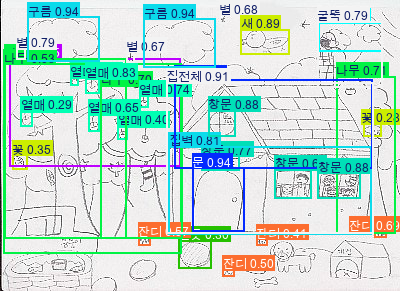

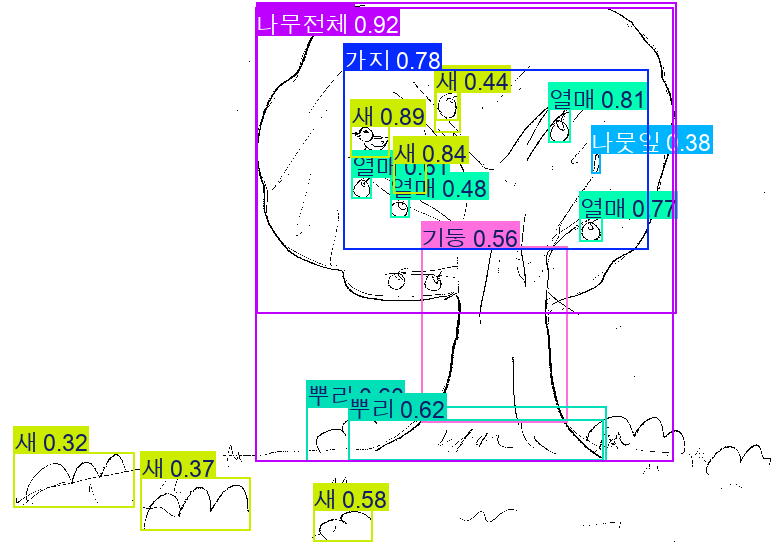

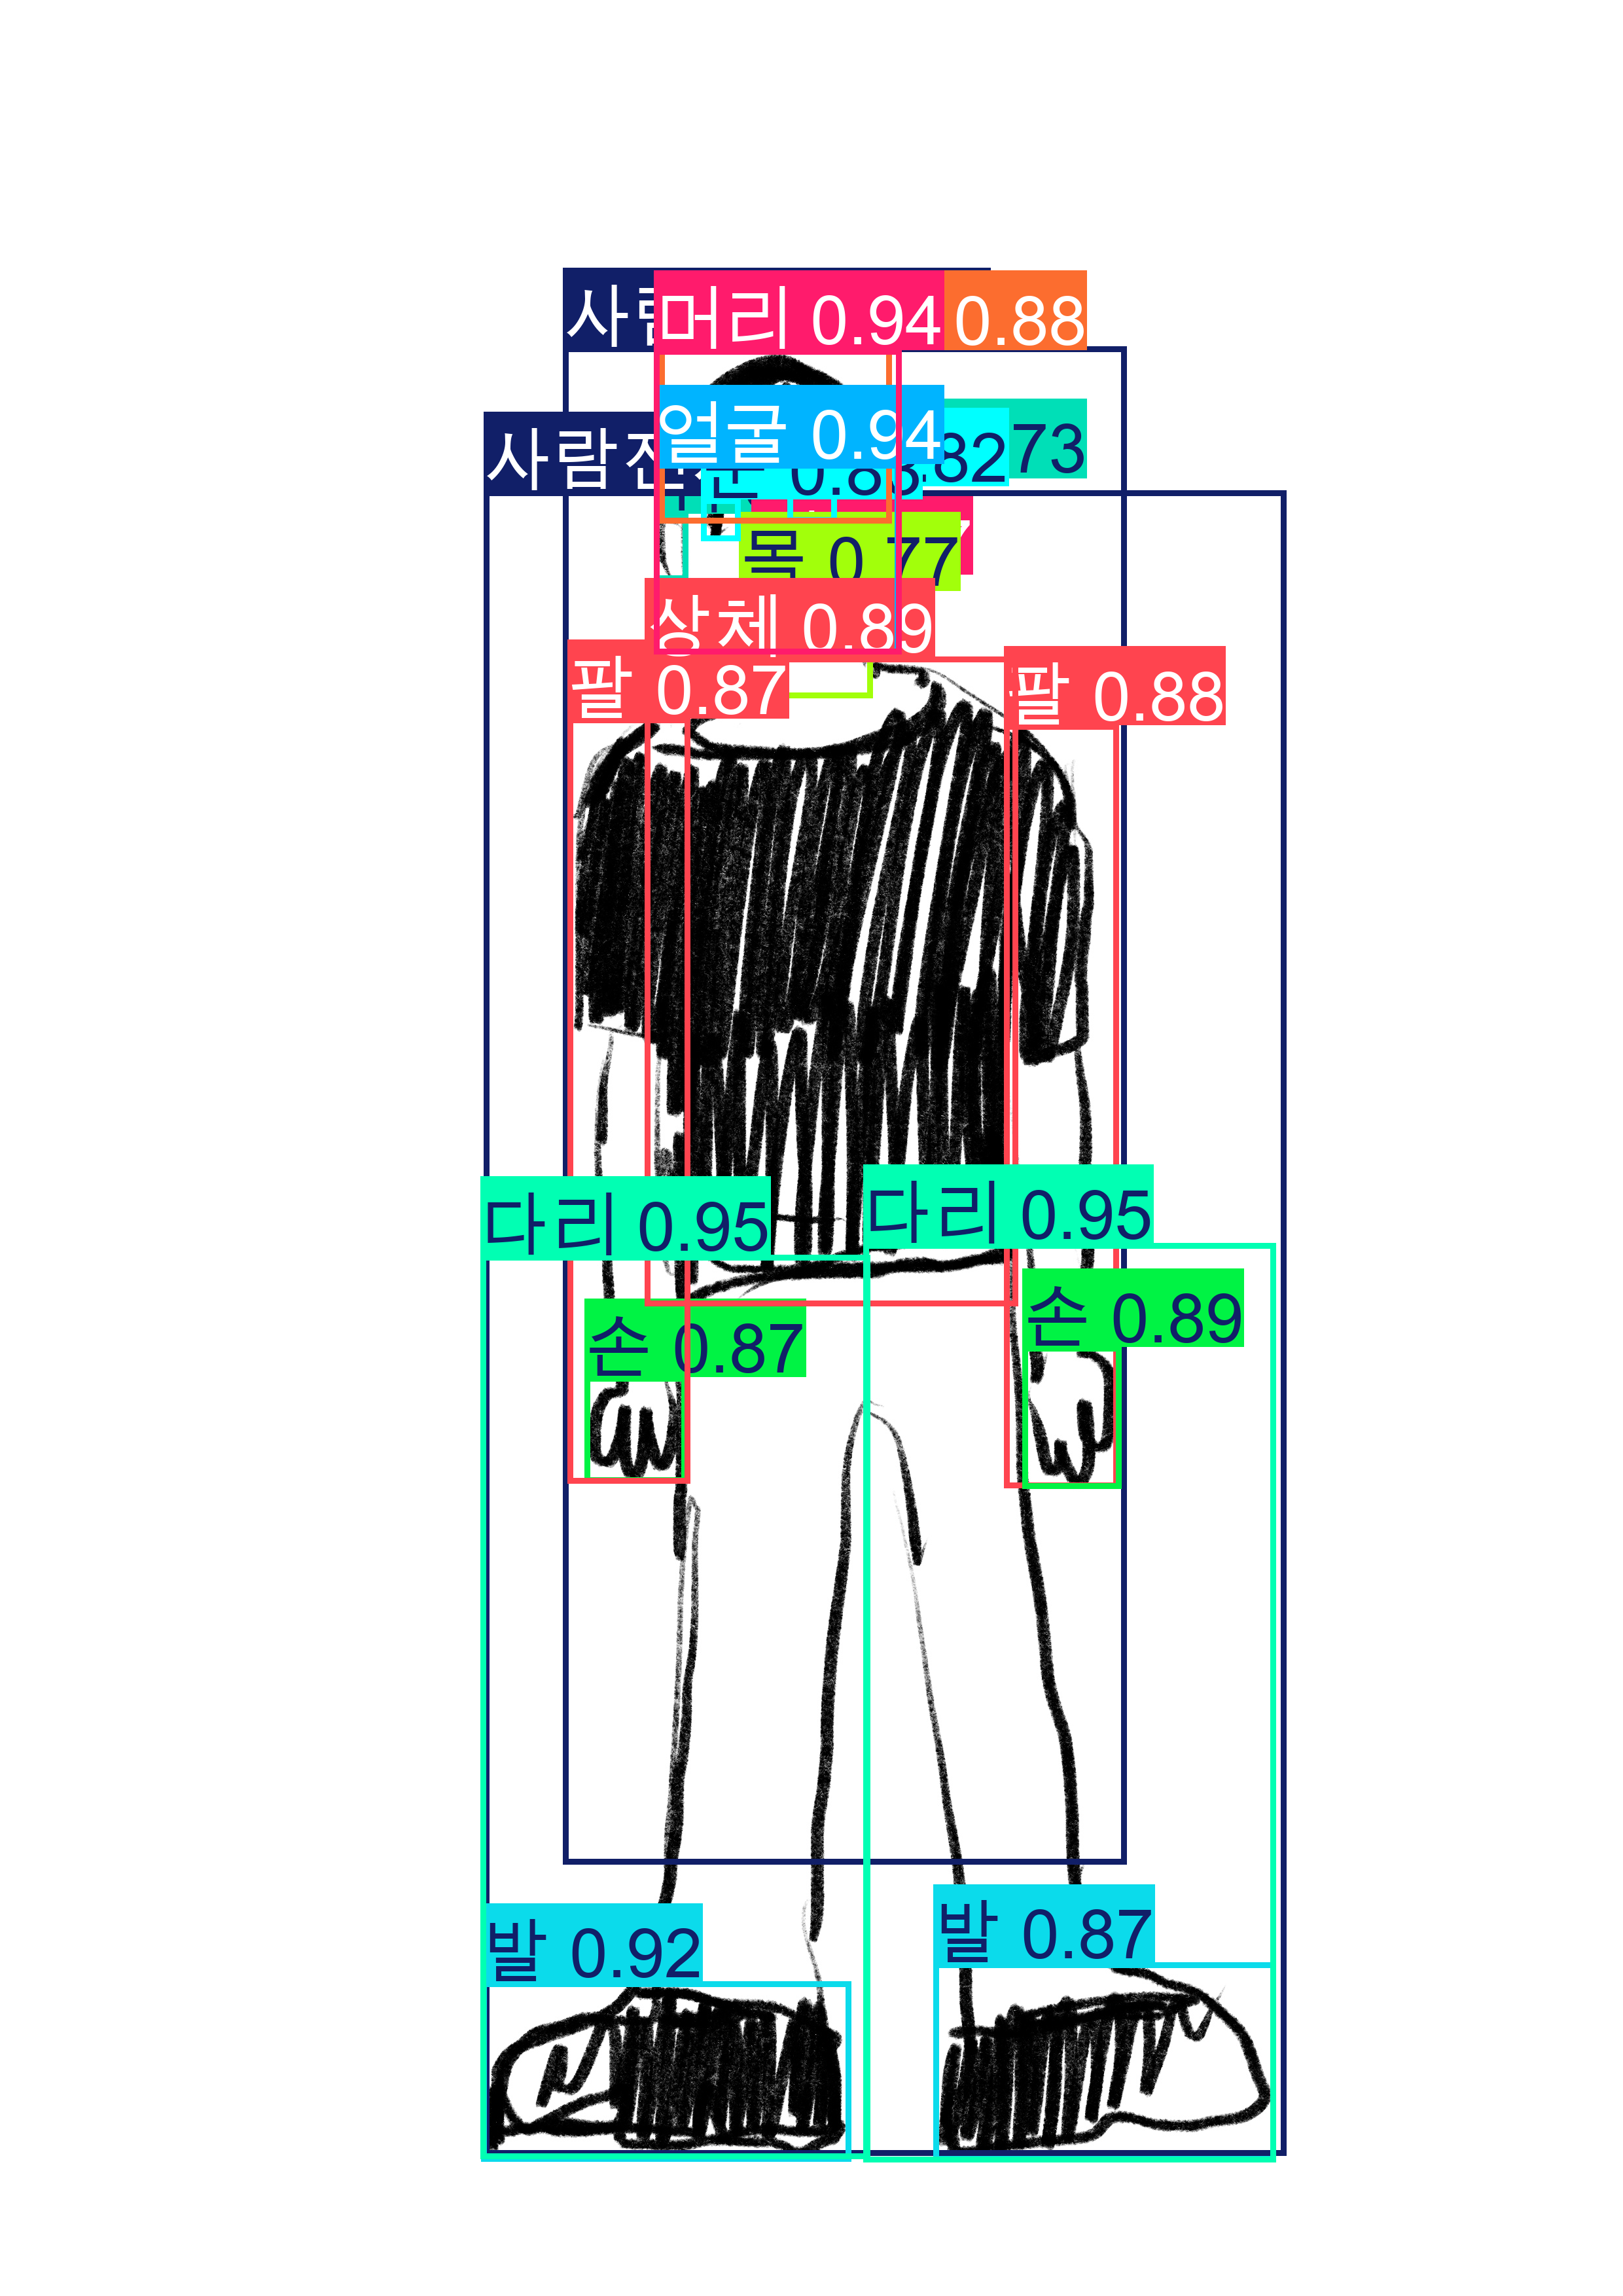

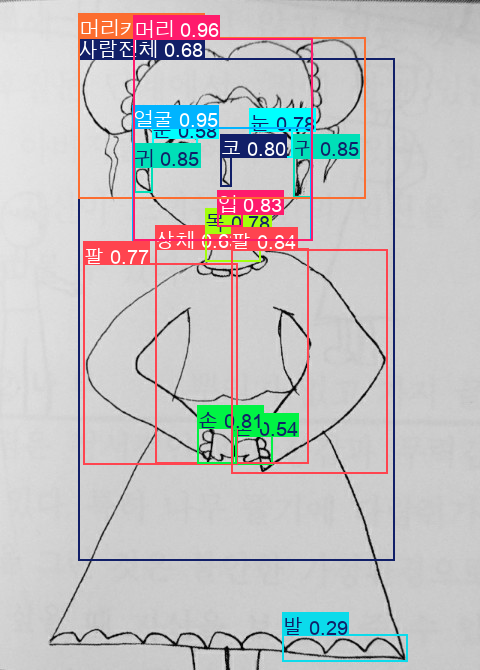

In [ ]:
htp_test = HTPTest('seungyu', '25', drawing_time=[5, 8, 10], cls_config_file='/work/creative_self_motivated/configs/child_painting.yaml', api_model='o4-mini', paper_type='A4')
htp_test.load_img(['/work/creative_self_motivated/example_data/house.jpg', # 집
                   '/work/creative_self_motivated/example_data/tree.jpg', #  나무
                   '/work/creative_self_motivated/example_data/person1.jpg', # 사람1
                   '/work/creative_self_motivated/example_data/person2.jpg']) # 사람2 -> 이 순서대로 입력되어야 함.

htp_test.create_client(api_key='Enter Your API Key Here!')

htp_test.run_detector(weight_path='/work/creative_self_motivated/runs/child_painting/run1/weights/best.pt')
# analysis = htp_test.HTP_analysis()

htp_test.detected_result[0][0].show()
htp_test.detected_result[1][0].show()
htp_test.detected_result[2][0].show()
htp_test.detected_result[3][0].show()

htp_analysis = htp_test.HTP_analysis()


In [16]:
# result of the House-Tree-Person analysis
htp_analysis

[[['공상에 열중하며 외면적인 대인관계로부터 도피하려는 경향'],
  ['집착적인 사람'],
  ['피검자의 마음 속에 긴장이 존재하며 가정환경내에 갈등이나 정서 혼란이 있음'],
  ['미래에 대한 염세적인 생각을 가짐'],
  ['방어벽을 만들려는 시도 만약 산책길과 연결된 경우, 어느정도 불안이 있으나 그것을 통제하고자 하는 의식적인 시도'],
  ['자의식이 강하고 내향적 성향', '퇴행적상황, 공상적, 여성경향', '총동적으로 만족을 구하려는 경향성']],
 [['병적 징후로 통제하기 힘든 충동이 존재, 자아붕괴'],
  ['무력감 부적응'],
  ['낮은 에너지와 종종 살아가려는 의지가 부족한 것과 관련됨'],
  ['자기의 발전과 활동이 억제되어 개방적이며 여러가지 흥미를 가지지만 자신의 충동을 적절히 통제하지 못함'],
  ['비판성과 감수성이 강하며 적의와 공격적 충동이 강함'],
  ['환경으로부터 만족을 얻으려고 하지 않는 사람'],
  ['자기중심적', '불안정한 경우 스스로 통제하여 마음의 안정을 유지하려는 사람']],
 [['강박증 환자들, 지적 부족감'],
  ['내적인 공허감 타인의 감정을 알고 싶지도 자신의 감정을 보이고 싶지도 않음'],
  ['감정 교류 소통의 채널을 좁힘. 타인과의 감정 교류나 감정 표현에 있어 스스로 한계를 느낌'],
  ['세력되고 몸치장을 잘함'],
  ['야성적, 거친, 억제되지 않음'],
  ['사회적 상호작용에서 위축되고 회피하고자 함. 자아도취'],
  ['정서적 자극을 피하고 싶고 위축되어 있음'],
  ['성에 대해 무엇인가 갈등이 있으며 남성적인 것을 거부하며 거세불안이 있고 동성애 경향이 있을 가능성이 있음 타인에게 어떻게 보일지에 매우 예민하고 두려워 함'],
  ['내적인 상처를 받지 않으려고 정서적 상호작용을 회피하거나 타인의 애정어린 태도를 거절하고자 함, 이와 관련하여 절망감이나 우울감을 느낌'],
  ['자기중심적', '불안정한 경우 스스로 통제하여 마음의 안정을 유지하려는 사

#### OpenAI Chat API

In [ ]:
from openai import OpenAI
client = OpenAI(
    api_key="Use Your Own API Key Here"
)

completion = client.chat.completions.create(
    model="gpt-4.1",
    store=True,
    messages=[
        {'role': 'user', 'content': 'how can i use multi-modal model by openai api'}
    ]
)

print(completion.choices[0].message)

In [12]:
htp_analysis[0] # house
htp_analysis[1] # tree
htp_analysis[2] # person1
htp_analysis[3] # person2

[['자기중심적', '불안정한 경우 스스로 통제하여 마음의 안정을 유지하려는 사람']]

In [11]:
completion = client.chat.completions.create(
    model="gpt-4.1-mini",
    store=True,
    messages=[
        {'role': 'system', 'content': 'your are the chatbot that professionally create the report for given HTP analysis. the report should include how is the patient\'s personality or mental state and how can they \
            manage or improve their mental state.'},
        {'role': 'user', 'content': f"""here is the house-tree-person analysis sentence: \
            1. house: {htp_analysis[0]}\
            2. tree: {htp_analysis[1]}\
            3. person1: {htp_analysis[2]}\
            4. person2: {htp_analysis[3]}\
            based on this analysis create a diagnosis report for HTP test. \
            
            output should be in this form: 
            1. House: 
            2. Tree:
            3. Person1:
            4. Person2:
            
            Recommendations for Patients:
            """}
    ]
)

print(completion.choices[0].message.content)

1. House:
The drawing of the house indicates that the patient has a conscious attempt to build protective barriers, especially when the house is connected to a pathway, suggesting underlying anxiety that they strive to control. The patient demonstrates balanced and appropriate cognitive activity, reflecting a realistic approach to life. There is a strong self-awareness with an introverted personality style. Additionally, tendencies toward regression, fantasy, feminine characteristics, and a drive for overall satisfaction are evident.

2. Tree:
The tree drawing reveals a self-centered nature. However, in moments of instability or anxiety, the patient makes efforts to regain control and maintain emotional stability, indicating some degree of resilience and self-regulation.

3. Person1:
The figure exhibits traits commonly found in obsessive-compulsive tendencies and feelings of intellectual inadequacy. There is social withdrawal and avoidance, accompanied by narcissistic behaviors. Emotio

#### OpenAI API Multi-Modal for more analysis


image 1/1 /work/creative_self_motivated/example_data/tree.jpg: 928x1280 1 가지, 1 기둥, 1 나무전체, 1 나뭇잎, 2 뿌리s, 8 새s, 1 수관, 4 열매s, 13.3ms
Speed: 34.1ms preprocess, 13.3ms inference, 1.5ms postprocess per image at shape (1, 3, 928, 1280)


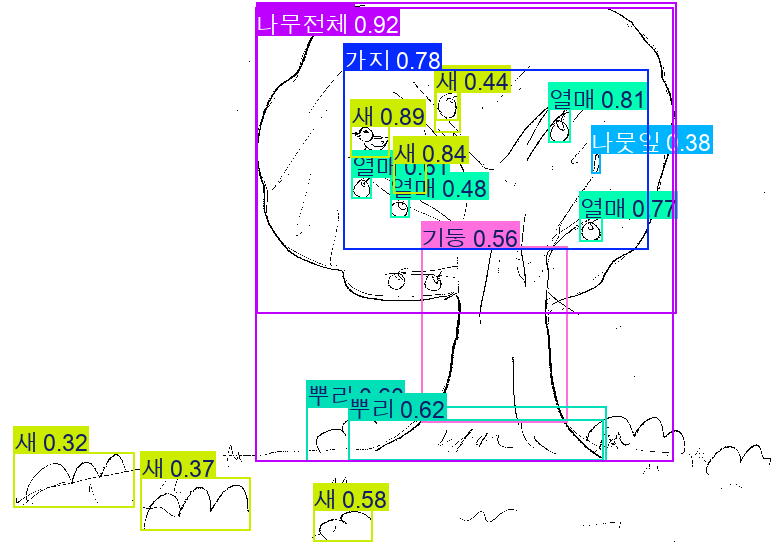

In [9]:
result = trained_yolo(source='/work/creative_self_motivated/example_data/tree.jpg', imgsz=1280)
for res in result:
    res.show()

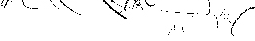

type of root_img:  <class 'PIL.Image.Image'>


In [10]:
with open('/work/creative_self_motivated/configs/child_painting.yaml', 'r') as yaml_read:
    configs = yaml.load(yaml_read, Loader=yaml.FullLoader)

cls2idx = {v: k for k, v in configs['names'].items()}

for res in result:
    boxes = res.boxes
    cls = boxes.cls.int().detach().cpu().numpy()
    xywh = boxes.xywh.detach().cpu().numpy()
    ori_img = res.orig_img
    
    xywh_root = xywh[cls==cls2idx['뿌리']]
    root_h = int(xywh_root[0][3])
    root_w = int(xywh_root[0][2])
    root_x = int(xywh_root[0][0])
    root_y = int(xywh_root[0][1])
    root_img = ori_img[root_y:root_y+root_h, root_x:root_x+root_w, :]
    root_img_vis = Image.fromarray(root_img)
    ori_img = Image.fromarray(ori_img)
    root_img_vis.show()
    
print("type of root_img: ", type(root_img_vis))

In [ ]:
# byte 타입으로 저장하고 base64로 인코딩하기
buffered = io.BytesIO()
root_img_vis.save(buffered, format="PNG")
root_img = buffered.getvalue()

base64_str = base64.b64encode(root_img).decode('utf-8')
data_url = f"data:image/png;base64, {base64_str}"

buffered = io.BytesIO()
ori_img.save(buffered, format="PNG")
ori_img = buffered.getvalue()

base64_str = base64.b64encode(ori_img).decode('utf-8')
ori_data_url = f"data:image/png;base64, {base64_str}"

In [56]:
completion = client.chat.completions.create(
    model="gpt-4.1-mini",
    store=True,
    messages=[
        {'role': 'system', 'content': 'You are an analyzer who accurately and professionally analyzes the images given for the HTP test. You answer user"s questions accurately and confidently, and do not give unnecessary answers other than the user"s questions.'},
        {'role': 'user', 
         'content': [
             {'type': 'text', 'text': f"""The given images are images of the whole tree and images of only the roots extracted from the whole tree image. For each of the four questions, answer only 'yes' or 'no' if applicable.
              
                The coordinates of the root extracted from the whole image are: {root_x, root_y, root_w, root_h} in (x, y, w, h) format.
                
                User Questions:
                1. In the given second image, are the roots clearly dried and dead?.
                2. Is the picture drawn so that the roots are visible through the ground?.
                3. Are the roots drawn at the edge of the drawing paper? (root must be located in the corner of the first image clearly).
                4. Are the tree roots emphasized in the images?).

                Answers:
                1: (answer here)
                2: (answer here)
                3: (answer here)
                4: (answer here)"""},
             {'type': 'image_url', 'image_url': {'url': ori_data_url}},
             {'type': 'image_url', 'image_url': {'url': data_url}}
         ]}
    ]
)

print(completion.choices[0].message.content)

1: no
2: no
3: no
4: no


In [57]:
answer = [x.strip() for x in completion.choices[0].message.content.split('\n')]
answer = [x.split(':')[-1].strip() for x in answer if ':' in x]
answer

['no', 'no', 'no', 'no']

In [ ]:
a = "{{{} {} {} {}}}"
a.format(1,2,3,4)
a

'{{{} {} {} {}}}'